In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
#from scipy.optimize import curve_fit

#import scvi
import pickle
#from adjustText import adjust_text
#import matplotlib.patches as patches
import itertools
import os
import networkx as nx
import networkx.algorithms.community as nx_comm
from scipy import spatial
from matplotlib import cm
import matplotlib as mpl

In [2]:
#import markers and convert to human format


with open('../data/gene_lists/human_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role

markers = {k.upper(): v for k, v in markers.items()}



#add senmayo

senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist()
#senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}
markers = markers | senmayo


In [14]:
adata = sc.concat((sc.read_h5ad('/home/jrlab/Downloads/HUMAN_CELLS_MS0203.h5ad')
                   ,sc.read_h5ad('/home/jrlab/Downloads/TS_harmonized.h5ad')))

hippo = sc.read_h5ad('/home/jrlab/Downloads/human_hippo_harmonized.h5ad')

In [16]:
#annotate data
with open('../data/annotations/human/liver_index_dictionary.pickle', 'rb') as handle:
     fin_liver_d = pickle.load(handle)

with open('../data/annotations/human/skin_index_dictionary.pickle', 'rb') as handle:
     fin_skin_d = pickle.load(handle)
        
with open('../data/annotations/human/lung_index_dictionary.pickle', 'rb') as handle:
     fin_lung_d = pickle.load(handle)
   
with open('../data/annotations/human/hcl_index_dictionary.pickle', 'rb') as handle:
     fin_hcl_d = pickle.load(handle)
        
with open('../data/annotations/human/hippo_index_dictionary.pickle', 'rb') as handle:
     fin_hippo_d = pickle.load(handle)

big_d = fin_liver_d | fin_skin_d | fin_lung_d | fin_hcl_d | fin_hippo_d


adata.obs['temp_id'] = adata.obs.index

def cell_type_mapper(x):
    cell, cell_type = x
    if cell_type == 'not typed':
        try:
            return big_d[cell]
        except:
            return 'drop'
    else:
        return cell_type
    
adata.obs.cell_type = adata.obs[['temp_id', 'cell_type']].apply(cell_type_mapper, axis = 1)
adata = adata[adata.obs.cell_type != 'drop']
adata.obs['is_na'] = adata.obs.isnull().sum(axis = 1) #cell_type_mapper returns NA if not in dict
adata = adata[adata.obs['is_na'] == 0]
adata.obs = adata.obs.drop(columns = ['temp_id', 'is_na'])


relabel_d = pd.read_csv('../data/annotations/human/harmonized_all_cell_counts.csv').dropna()
relabel_d = dict(zip(relabel_d.cell_type, relabel_d.new_label))

def a_mapper(x):
    try:
        return relabel_d[x].strip().lower()
    except:
        return x.strip().lower()
    
adata.obs['cell_type_2'] = adata.obs.cell_type.map(a_mapper)


adata.obs.tissue = adata.obs.tissue.map(lambda x: x.lower())
adata.obs.tissue = adata.obs.tissue.map(lambda x: x.replace('_', ' ').replace('-', ' '))
adata.obs.tissue = adata.obs.tissue.replace('fat', 'adipose')
adata.obs.tissue = adata.obs.tissue.replace('peripheral blood', 'blood')

/tmp/ipykernel_2263831/3091437583.py:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['is_na'] = adata.obs.isnull().sum(axis = 1) #cell_type_mapper returns NA if not in dict


In [17]:
hippo = hippo[~hippo.obs.cell_type.isna()]
hippo.obs['cell_type_2'] = hippo.obs.cell_type #just to make similar to adata

/tmp/ipykernel_2263831/351556575.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hippo.obs['cell_type_2'] = hippo.obs.cell_type #just to make similar to adata


In [18]:
#bins age in 10 year bins
def age_bin(x):
    for y in range(18,92,10):
        if y > x:
            return y - 10
    return y

In [19]:
adata.obs['bin_age'] = adata.obs.age.map(age_bin)

In [20]:
'''
criteria:
must have at least 3 bins with > 100 cells each OR a bin in 18-28 and 58-68
must have one bin >=age48 with > 100 cells
'''
def remove_limited_data(x):
    #[18,28,38,48,58,68]
    #[0 ,1 ,2 ,3 ,4 ,5 ]
    
    if len(x[x > 100]) < 3 or (len(x[0:2][x[0:2] > 100]) == 0 and len(x[4:][x[4:] > 100]) == 0):
        return False
    if len(x[3:][x[3:] > 100]) < 1:
        return False
    
    return True

In [21]:
'''
v2: in individual study, to reduce effects from differences in gene coverage

'''


df = adata.obs.groupby(['tissue', 'cell_type_2', 'bin_age', 'study'], observed = True).count().reset_index()
df = df.pivot(values='cell_type', index = ['tissue', 'cell_type_2', 'study'], columns = 'bin_age').reset_index()
df[[18,28,38,48,58,68]] = df[[18,28,38,48,58,68]].fillna(0)
df
    


bin_age,tissue,cell_type_2,study,18,28,38,48,58,68
0,adipose,b cell,TS,0.0,23.0,0.0,0.0,0.0,0.0
1,adipose,endothelial cell,TS,0.0,1872.0,0.0,0.0,1876.0,0.0
2,adipose,fibroblast,TS,0.0,6263.0,0.0,0.0,2196.0,0.0
3,adipose,fibroblast,hcl,0.0,228.0,0.0,0.0,0.0,0.0
4,adipose,leucocyte,TS,0.0,157.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...
550,vasculature,nk cell,TS,0.0,0.0,0.0,0.0,121.0,0.0
551,vasculature,pericyte,TS,0.0,0.0,0.0,0.0,1193.0,0.0
552,vasculature,plasma cell,TS,0.0,0.0,0.0,0.0,42.0,0.0
553,vasculature,smooth muscle cell,TS,0.0,0.0,0.0,0.0,3075.0,0.0


In [22]:
df = df[df[[18,28,38,48,58,68]].apply(remove_limited_data, axis = 1)]
df = df.reset_index(drop = True)
len(df)

47

In [23]:
df.groupby(['tissue', 'study'], observed = True).sum().reset_index()
#check to make sure only one study per tissue, or will have to choose study with better representation

bin_age,tissue,study,cell_type_2,18,28,38,48,58,68
0,blood,TS,erythrocytememory b cellmonocytenaive b cellne...,0.0,4892.0,0.0,1934.0,24455.0,16961.0
1,bone marrow,TS,t cell,116.0,0.0,1002.0,0.0,2054.0,0.0
2,heart,heart,adipocytecardiomyocyteendothelial cellfibrobla...,0.0,0.0,59210.0,160971.0,235810.0,28802.0
3,intestine,hcl,epithelial cellmacrophageplasma cellunknown,0.0,0.0,6178.0,1483.0,3474.0,0.0
4,kidney,hcl,endothelial cellepithelial cellmacrophage,0.0,0.0,15526.0,2626.0,12489.0,0.0
5,liver,liver,endothelial cellmacrophagemonocytet cell,1683.0,0.0,2496.0,0.0,2344.0,0.0
6,lung,lung,basal cellciliated epithelial cellclub cellend...,11046.0,11850.0,12609.0,23586.0,9798.0,10882.0
7,skin,skin,basal cellendothelial cellfibroblastgranular c...,21356.0,0.0,12371.0,5921.0,0.0,0.0
8,tongue,TS,basal cell,0.0,0.0,164.0,0.0,762.0,5355.0


In [24]:
hippo.obs['bin_age'] = hippo.obs.age.map(age_bin)
hippo.obs['study'] = 'hippo'

In [25]:
dfh = hippo.obs.groupby(['tissue', 'cell_type_2', 'bin_age', 'study']).count().reset_index()
dfh = dfh.pivot(values='cell_type', index = ['tissue', 'cell_type_2', 'study'], columns = 'bin_age').reset_index()
dfh[28] = 0
dfh = dfh[['tissue','cell_type_2', 'study', 8,18,28,38,48,58,68,78,88]]
#dfh = dfh.fillna(0)
dfh

/tmp/ipykernel_2263831/2563871332.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfh = hippo.obs.groupby(['tissue', 'cell_type_2', 'bin_age', 'study']).count().reset_index()


bin_age,tissue,cell_type_2,study,8,18,28,38,48,58,68,78,88
0,hippocampus,GABA interneuron,hippo,5803,137,0,967,794,1242,2347,3096,2217
1,hippocampus,astrocyte,hippo,5284,510,0,2129,802,2060,3080,3347,3491
2,hippocampus,cajal-retzius cell,hippo,39,2,0,22,0,21,11,15,10
3,hippocampus,choroid plexus cells,hippo,631,59,0,7,3,356,528,517,218
4,hippocampus,dentate granule cell,hippo,10935,186,0,10649,879,1545,6994,6512,6179
5,hippocampus,endothelial cells,hippo,485,27,0,282,51,119,443,318,277
6,hippocampus,ependymal cell,hippo,345,18,0,218,53,126,424,265,342
7,hippocampus,excitatory neuron,hippo,22361,189,0,1675,6877,3606,7998,8071,8087
8,hippocampus,microglia,hippo,1323,533,0,447,473,640,1105,1799,1009
9,hippocampus,oligodendrocyte,hippo,6878,2875,0,2691,5607,2577,6694,12747,6702


In [26]:
hippo_not_enough = ['cajal-retzius cell']
dfh = dfh[~dfh.cell_type_2.isin(hippo_not_enough)].reset_index(drop = True)
dfh['hippo'] = 'yes'
dfh

bin_age,tissue,cell_type_2,study,8,18,28,38,48,58,68,78,88,hippo
0,hippocampus,GABA interneuron,hippo,5803,137,0,967,794,1242,2347,3096,2217,yes
1,hippocampus,astrocyte,hippo,5284,510,0,2129,802,2060,3080,3347,3491,yes
2,hippocampus,choroid plexus cells,hippo,631,59,0,7,3,356,528,517,218,yes
3,hippocampus,dentate granule cell,hippo,10935,186,0,10649,879,1545,6994,6512,6179,yes
4,hippocampus,endothelial cells,hippo,485,27,0,282,51,119,443,318,277,yes
5,hippocampus,ependymal cell,hippo,345,18,0,218,53,126,424,265,342,yes
6,hippocampus,excitatory neuron,hippo,22361,189,0,1675,6877,3606,7998,8071,8087,yes
7,hippocampus,microglia,hippo,1323,533,0,447,473,640,1105,1799,1009,yes
8,hippocampus,oligodendrocyte,hippo,6878,2875,0,2691,5607,2577,6694,12747,6702,yes
9,hippocampus,oligodendrocyte precursor cell,hippo,3823,253,0,1092,655,1489,1780,2169,2318,yes


In [27]:
df['hippo'] = 'no'
df[8] = 0
df[78] = 0
df[88] = 0
df = df[dfh.columns]
df = pd.concat((df, dfh)).reset_index(drop = True)

In [29]:
df

bin_age,tissue,cell_type_2,study,8,18,28,38,48,58,68,78,88,hippo
0,blood,erythrocyte,TS,0,0.0,824.0,0.0,1.0,2060.0,7599.0,0,0,no
1,blood,memory b cell,TS,0,0.0,273.0,0.0,47.0,267.0,267.0,0,0,no
2,blood,monocyte,TS,0,0.0,2056.0,0.0,225.0,10847.0,3063.0,0,0,no
3,blood,naive b cell,TS,0,0.0,766.0,0.0,26.0,718.0,729.0,0,0,no
4,blood,neutrophil,TS,0,0.0,0.0,0.0,1567.0,5858.0,1031.0,0,0,no
5,blood,nk cell,TS,0,0.0,514.0,0.0,10.0,715.0,1709.0,0,0,no
6,blood,t cell,TS,0,0.0,459.0,0.0,58.0,3990.0,2563.0,0,0,no
7,bone marrow,t cell,TS,0,116.0,0.0,1002.0,0.0,2054.0,0.0,0,0,no
8,heart,adipocyte,heart,0,0.0,0.0,791.0,1617.0,1155.0,236.0,0,0,no
9,heart,cardiomyocyte,heart,0,0.0,0.0,28434.0,63541.0,46850.0,9947.0,0,0,no


In [37]:
len(df)

57

In [44]:
cell_type_2_annotations = pd.read_csv('../data/annotations/human/cell_classes.csv')

class_d = dict(zip(cell_type_2_annotations.cell_type_2, cell_type_2_annotations['class']))
compartment_d = dict(zip(cell_type_2_annotations.cell_type_2, cell_type_2_annotations['compartment']))

In [416]:
temp = []
for tissue, cell, study in tqdm(list(zip(df.tissue, df.cell_type_2, df.study))):
    for age in [8,18,28,38,48,58,68,78,88]:
        if tissue != 'hippocampus':
            sdata = adata[(adata.obs.tissue == tissue) & (adata.obs.cell_type_2 == cell) &\
                          (adata.obs.bin_age.astype('int') == age) &\
                          (adata.obs.study == study)].X.toarray()
            svars = adata.var_names
        else:
            sdata = hippo[(hippo.obs.tissue == tissue) & (hippo.obs.cell_type_2 == cell) &\
                          (hippo.obs.bin_age.astype('int') == age)].X.toarray()
            svars = hippo.var_names
        
        for gene in svars:
            temp2 = [tissue, cell, age, gene]
            if len(sdata) > 100:
                i = np.where(svars == gene)[0][0]
                a = sdata[:,i]
                v = a[a > 0].shape[0] / a.shape[0]
            else:
                v = -1
            temp2 += [v]
            temp.append(temp2)
            
            
tc_df = pd.DataFrame(temp, columns = ['tissue', 'cell_type_2', 'age_bin', 'gene', 'value'])

tc_df = tc_df.pivot(values = 'value', index = ['tissue','cell_type_2', 'gene'], columns = 'age_bin').reset_index()

tc_df['Class'] = tc_df.cell_type_2.map(class_d)
tc_df['compartment'] = tc_df.cell_type_2.map(compartment_d)
#tc_df.to_pickle('../data/files/6_ALL_GENE_cell_counts_HUMAN.pickle')



def gene_stats(x):
    ages = np.array([8,18,28,38,48,58,68,78,88])
    mask = x > -1
    
    ages = ages[mask]
    x = x[mask]
    
    lin = stats.linregress(ages, x)
    
    if 18 in ages or 28 in ages or 8 in ages:
        starting = x.iloc[0]
    else:
        starting = lin.slope*18 + lin.intercept
        
    if starting < 0:
        starting = 0
        
    ending = x.iloc[-1]

    return lin.slope, x.iloc[0], x.max(), lin.pvalue, len(x), starting, ending
    
    
tqdm.pandas()
tc_df['slope'], tc_df['starting'], tc_df['Max'], tc_df['lin_p'], tc_df['N'], tc_df['starting'], tc_df['ending'] =\
zip(*tc_df[[8,18,28,38,48,58,68,78,88]].progress_apply(gene_stats, axis = 1))


tc_df['gain'] = tc_df.ending - tc_df.starting

tc_df.to_pickle('../data/files/6_ALL_GENE_cell_counts_HUMAN.pickle')


tc_df = pd.read_pickle('../data/files/6_ALL_GENE_cell_counts_HUMAN.pickle')

tc_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1257347/1257347 [10:55<00:00, 1917.85it/s]


age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,88,Class,compartment,slope,starting,Max,lin_p,N,ending,gain
0,blood,erythrocyte,A1BG,-1.0,-1.0,0.000000,-1.000000,-1.0,0.000485,0.000132,...,-1.0,immune,immune,0.000006,0.000000,0.000485,0.652266,3,0.000132,0.000132
1,blood,erythrocyte,A1BG-AS1,-1.0,-1.0,0.000000,-1.000000,-1.0,0.000971,0.001579,...,-1.0,immune,immune,0.000038,0.000000,0.001579,0.095007,3,0.001579,0.001579
2,blood,erythrocyte,A1CF,-1.0,-1.0,0.000000,-1.000000,-1.0,0.000000,0.000000,...,-1.0,immune,immune,0.000000,0.000000,0.000000,1.000000,3,0.000000,0.000000
3,blood,erythrocyte,A2M,-1.0,-1.0,0.000000,-1.000000,-1.0,0.000000,0.000921,...,-1.0,immune,immune,0.000018,0.000000,0.000921,0.512246,3,0.000921,0.000921
4,blood,erythrocyte,A2M-AS1,-1.0,-1.0,0.001214,-1.000000,-1.0,0.000000,0.000921,...,-1.0,immune,immune,-0.000015,0.001214,0.001214,0.672789,3,0.000921,-0.000292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257342,tongue,basal cell,ZYG11A,-1.0,-1.0,-1.000000,0.000000,-1.0,0.007874,0.011018,...,-1.0,progenitor,epithelial,0.000371,0.000000,0.011018,0.033647,3,0.011018,0.011018
1257343,tongue,basal cell,ZYG11B,-1.0,-1.0,-1.000000,0.060976,-1.0,0.337270,0.256022,...,-1.0,progenitor,epithelial,0.007546,0.000000,0.337270,0.397004,3,0.256022,0.256022
1257344,tongue,basal cell,ZYX,-1.0,-1.0,-1.000000,0.030488,-1.0,0.204724,0.216246,...,-1.0,progenitor,epithelial,0.006552,0.000000,0.216246,0.177040,3,0.216246,0.216246
1257345,tongue,basal cell,ZZEF1,-1.0,-1.0,-1.000000,0.067073,-1.0,0.233596,0.279925,...,-1.0,progenitor,epithelial,0.007271,0.000000,0.279925,0.079594,3,0.279925,0.279925


In [3]:
tc_df = pd.read_pickle('../data/files/6_ALL_GENE_cell_counts_HUMAN.pickle')

In [4]:
#R1
with open('../data/files/R1_FILT_GENES_HUMAN.pickle', 'rb') as f:
    sel = pickle.load(f)

In [5]:
tc_df['tissue.cell'] = tc_df.tissue + '.' + tc_df.cell_type_2

In [6]:
[x for x in list(sel)]

['blood.erythrocyte',
 'blood.memory b cell',
 'blood.monocyte',
 'blood.naive b cell',
 'blood.neutrophil',
 'blood.nk cell',
 'blood.t cell',
 'bone marrow.t cell',
 'heart.adipocyte',
 'heart.cardiomyocyte',
 'heart.endothelial cell',
 'heart.fibroblast',
 'heart.lymphoid cell',
 'heart.myeloid cell',
 'heart.neuronal cell',
 'heart.pericyte',
 'heart.smooth muscle cell',
 'hippocampus.GABA interneuron',
 'hippocampus.astrocyte',
 'hippocampus.choroid plexus cells',
 'hippocampus.dentate granule cell',
 'hippocampus.endothelial cells',
 'hippocampus.ependymal cell',
 'hippocampus.excitatory neuron',
 'hippocampus.microglia',
 'hippocampus.oligodendrocyte',
 'hippocampus.oligodendrocyte precursor cell',
 'intestine.epithelial cell',
 'intestine.macrophage',
 'intestine.plasma cell',
 'kidney.endothelial cell',
 'kidney.epithelial cell',
 'kidney.macrophage',
 'liver.endothelial cell',
 'liver.macrophage',
 'liver.monocyte',
 'liver.t cell',
 'lung.basal cell',
 'lung.ciliated epithel

In [7]:
new_stats = []
not_there = []
for tissue_cell in tqdm(tc_df['tissue.cell'].unique()):
    _ = tc_df[tc_df['tissue.cell'] == tissue_cell]
    try:
        #fixxxxxxxxx this!!!!!!!!!!!!!!
        _ = _[_.gene.isin(sel[tissue_cell])]
        new_stats.append(_)
    except:
        not_there.append(tissue_cell)

    

100%|███████████████████████████████████████████| 57/57 [00:03<00:00, 16.36it/s]


In [8]:
not_there

['heart.unknown', 'intestine.unknown']

In [9]:
with open('R1/better_input_list_human.txt', 'w') as f:
    for x in tc_df['tissue.cell'].unique():
        f.write(x + '\n')

In [10]:
len(new_stats) #should be same length as sel

55

In [11]:
len(sel)

55

In [12]:
tc_df_filt = pd.concat(new_stats) #overwriting cell_stats with R1 filtered stats
tc_df_filt

age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,Class,compartment,slope,starting,Max,lin_p,N,ending,gain,tissue.cell
35,blood,erythrocyte,ABALON,-1.0,-1.0,0.021845,-1.000000,-1.0,0.106311,0.050270,...,immune,immune,0.001196,0.021845,0.106311,0.606526,3,0.050270,0.028425,blood.erythrocyte
65,blood,erythrocyte,ABCC4,-1.0,-1.0,0.012136,-1.000000,-1.0,0.031553,0.050533,...,immune,immune,0.000888,0.012136,0.050533,0.174721,3,0.050533,0.038397,blood.erythrocyte
80,blood,erythrocyte,ABCG2,-1.0,-1.0,0.019417,-1.000000,-1.0,0.042718,0.037242,...,immune,immune,0.000522,0.019417,0.042718,0.298739,3,0.037242,0.017824,blood.erythrocyte
634,blood,erythrocyte,ACRBP,-1.0,-1.0,0.020631,-1.000000,-1.0,0.011165,0.039084,...,immune,immune,0.000282,0.020631,0.039084,0.728600,3,0.039084,0.018453,blood.erythrocyte
670,blood,erythrocyte,ACTN1,-1.0,-1.0,0.030340,-1.000000,-1.0,0.047087,0.056586,...,immune,immune,0.000634,0.030340,0.056586,0.078252,3,0.056586,0.026247,blood.erythrocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257330,tongue,basal cell,ZSWIM4,-1.0,-1.0,-1.000000,0.000000,-1.0,0.049869,0.111858,...,progenitor,epithelial,0.003552,0.000000,0.111858,0.160813,3,0.111858,0.111858,tongue.basal cell
1257336,tongue,basal cell,ZW10,-1.0,-1.0,-1.000000,0.048780,-1.0,0.186352,0.113165,...,progenitor,epithelial,0.002822,0.012618,0.186352,0.569134,3,0.113165,0.100547,tongue.basal cell
1257340,tongue,basal cell,ZXDB,-1.0,-1.0,-1.000000,0.048780,-1.0,0.080052,0.090009,...,progenitor,epithelial,0.001401,0.021565,0.090009,0.063626,3,0.090009,0.068444,tongue.basal cell
1257341,tongue,basal cell,ZXDC,-1.0,-1.0,-1.000000,0.054878,-1.0,0.213911,0.154062,...,progenitor,epithelial,0.003970,0.000000,0.213911,0.455331,3,0.154062,0.154062,tongue.basal cell


In [433]:
#deprecated with R1
#ending can't be 50% less than the max and the max cant be <= age 38
# def extra_filt(x):
#     x = x[x >= 0]
#     if x.max() > 2*x.iloc[-1] or x.idxmax() <= 38: # 
#         return False
#     else:
#         return True

In [434]:
#deprecated with R1

# # tc_df_filt = tc_df[(tc_df.slope > 0) &\
# #       (tc_df.Max < 0.20) &\
# #       (tc_df.starting < .05) &\
# #       (tc_df.gain > 0.015)]

# tc_df_filt = tc_df[(tc_df.slope > 0) &\
#       (tc_df.Max < 0.2) &\
#       (tc_df.starting < .05) &\
#       (tc_df.gain > 0.015)]


# tqdm.pandas()
# tc_df_filt = tc_df_filt[tc_df_filt[[8,18,28,38,48,58,68,78,88]].progress_apply(extra_filt, axis = 1)]


# print(len(tc_df_filt[tc_df_filt.gene == 'CDKN2A']))

# tc_df_filt

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 67751/67751 [00:18<00:00, 3623.88it/s]


10


age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,88,Class,compartment,slope,starting,Max,lin_p,N,ending,gain
65,blood,erythrocyte,ABCC4,-1.0,-1.0,0.012136,-1.000000,-1.0,0.031553,0.050533,...,-1.0,immune,immune,0.000888,0.012136,0.050533,0.174721,3,0.050533,0.038397
80,blood,erythrocyte,ABCG2,-1.0,-1.0,0.019417,-1.000000,-1.0,0.042718,0.037242,...,-1.0,immune,immune,0.000522,0.019417,0.042718,0.298739,3,0.037242,0.017824
634,blood,erythrocyte,ACRBP,-1.0,-1.0,0.020631,-1.000000,-1.0,0.011165,0.039084,...,-1.0,immune,immune,0.000282,0.020631,0.039084,0.728600,3,0.039084,0.018453
670,blood,erythrocyte,ACTN1,-1.0,-1.0,0.030340,-1.000000,-1.0,0.047087,0.056586,...,-1.0,immune,immune,0.000634,0.030340,0.056586,0.078252,3,0.056586,0.026247
872,blood,erythrocyte,AFF1,-1.0,-1.0,0.031553,-1.000000,-1.0,0.066019,0.075010,...,-1.0,immune,immune,0.001101,0.031553,0.075010,0.028854,3,0.075010,0.043456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257319,tongue,basal cell,ZSCAN29,-1.0,-1.0,-1.000000,0.018293,-1.0,0.111549,0.108123,...,-1.0,progenitor,epithelial,0.003233,0.000000,0.111549,0.232918,3,0.108123,0.108123
1257320,tongue,basal cell,ZSCAN30,-1.0,-1.0,-1.000000,0.036585,-1.0,0.144357,0.097292,...,-1.0,progenitor,epithelial,0.002504,0.000921,0.144357,0.499185,3,0.097292,0.096371
1257330,tongue,basal cell,ZSWIM4,-1.0,-1.0,-1.000000,0.000000,-1.0,0.049869,0.111858,...,-1.0,progenitor,epithelial,0.003552,0.000000,0.111858,0.160813,3,0.111858,0.111858
1257336,tongue,basal cell,ZW10,-1.0,-1.0,-1.000000,0.048780,-1.0,0.186352,0.113165,...,-1.0,progenitor,epithelial,0.002822,0.012618,0.186352,0.569134,3,0.113165,0.100547


In [435]:
tc_df_filt[tc_df_filt.gene == 'CDKN2A'][tc_df_filt.columns[0:-2]]

age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,78,88,Class,compartment,slope,starting,Max,lin_p,N
25129,blood,memory b cell,CDKN2A,-1.000000,-1.000000,0.018315,-1.000000,-1.000000,0.056180,0.041199,-1.00000,-1.000000,immune,immune,0.000731,0.018315,0.056180,0.411416,3
133884,blood,t cell,CDKN2A,-1.000000,-1.000000,0.015251,-1.000000,-1.000000,0.045614,0.032384,-1.00000,-1.000000,immune,immune,0.000563,0.015251,0.045614,0.440591,3
155635,bone marrow,t cell,CDKN2A,-1.000000,0.017241,-1.000000,0.036926,-1.000000,0.037488,-1.000000,-1.00000,-1.000000,immune,immune,0.000506,0.017241,0.037488,0.317826,3
444851,hippocampus,choroid plexus cells,CDKN2A,0.007924,-1.000000,-1.000000,-1.000000,-1.000000,0.011236,0.017045,0.03675,0.027523,epithelial,epithelial,0.000292,0.007924,0.036750,0.133024,5
912709,lung,club cell,CDKN2A,-1.000000,0.004717,0.055336,0.053030,0.012755,0.028986,0.062802,-1.00000,-1.000000,epithelial,epithelial,0.000489,0.004717,0.062802,0.461910,6
1043215,lung,type ii pneumocyte,CDKN2A,-1.000000,0.001828,0.011241,0.003838,0.005464,0.005906,0.020285,-1.00000,-1.000000,epithelial,epithelial,0.000223,0.001828,0.020285,0.191746,6
1064966,skin,basal cell,CDKN2A,-1.000000,0.009023,-1.000000,0.050114,0.082192,-1.000000,-1.000000,-1.00000,-1.000000,progenitor,epithelial,0.002384,0.009023,0.082192,0.075838,3
1130219,skin,granular cell,CDKN2A,-1.000000,0.001666,-1.000000,0.004950,0.022093,-1.000000,-1.000000,-1.00000,-1.000000,parenchymal,stromal,0.000607,0.001666,0.022093,0.358687,3
1151970,skin,hair follicle,CDKN2A,-1.000000,0.003464,-1.000000,0.015152,0.018939,-1.000000,-1.000000,-1.00000,-1.000000,parenchymal,stromal,0.000526,0.003464,0.018939,0.061417,3
1217223,skin,spinous cell,CDKN2A,-1.000000,0.019778,-1.000000,0.137211,0.141593,-1.000000,-1.000000,-1.00000,-1.000000,parenchymal,stromal,0.004319,0.019778,0.141593,0.192106,3


In [13]:
#how many genes in each cell context
how_many = tc_df_filt.groupby(['tissue', 'cell_type_2']).count().\
reset_index().sort_values('gene', ascending = False).reset_index(drop = True)


how_many = how_many[['tissue', 'cell_type_2', 'gene']]

how_many

age_bin,tissue,cell_type_2,gene
0,skin,granular cell,5771
1,bone marrow,t cell,4347
2,skin,basal cell,4072
3,skin,fibroblast,3668
4,skin,spinous cell,3198
5,heart,cardiomyocyte,3098
6,tongue,basal cell,2704
7,hippocampus,excitatory neuron,2408
8,skin,mitotic cell,2131
9,lung,basal cell,1967


In [30]:
study_d = dict(zip((df.tissue + df.cell_type_2), df.study))

def how_many_sen_markers(x):
    tissue, cell = x
    genes = tc_df_filt[(tc_df_filt.tissue == tissue) & (tc_df_filt.cell_type_2 == cell)].gene.tolist()
    return len([x for x in genes if x in list(markers)])


how_many['sen_num'] = how_many[['tissue', 'cell_type_2']].apply(how_many_sen_markers, axis = 1)
how_many['study'] = (how_many.tissue + how_many.cell_type_2).map(study_d)
                                                                
how_many

age_bin,tissue,cell_type_2,gene,sen_num,study
0,skin,granular cell,5771,38,skin
1,bone marrow,t cell,4347,15,TS
2,skin,basal cell,4072,31,skin
3,skin,fibroblast,3668,23,skin
4,skin,spinous cell,3198,34,skin
5,heart,cardiomyocyte,3098,29,heart
6,tongue,basal cell,2704,31,TS
7,hippocampus,excitatory neuron,2408,16,hippo
8,skin,mitotic cell,2131,23,skin
9,lung,basal cell,1967,25,lung


In [32]:
#!mv ../data/files/human_corr_subs/ ../data/files/human_corr_subs_bak
#!mkdir ../data/files/human_corr_subs/

In [33]:
#make subset adata

for i in tqdm(range(len(how_many))):
    tissue = how_many.iloc[i].tissue
    cell = how_many.iloc[i].cell_type_2
    study = how_many.iloc[i].study
    genes = tc_df_filt[(tc_df_filt.tissue == tissue) & (tc_df_filt.cell_type_2 == cell)].gene.tolist()
    
    
    if tissue != 'hippocampus':
        sdata = adata[(adata.obs.tissue == tissue) & (adata.obs.cell_type_2 == cell) &\
                      (adata.obs.bin_age.astype('int') >= 48) &\
                      (adata.obs.study == study)][:,genes].copy()
    else:
        sdata = hippo[(hippo.obs.tissue == tissue) & (hippo.obs.cell_type_2 == cell) &\
                      (hippo.obs.bin_age.astype('int') >= 48)][:,genes].copy()

    out_str = '../data/files/human_corr_subs/' + tissue + '__' + cell + '.h5ad'
    out_str = out_str.replace(' ','_')
    
    
    if len(sdata) < 100:
        print('adfadfadfadasdfdf')
        print('adfadfadfadasdfdf')
        print('adfadfadfadasdfdf')
        print('adfadfadfadasdfdf')
        print('adfadfadfadasdfdf')
        print('adfadfadfadasdfdf')
        print('adfadfadfadasdfdf')
        break
    
    
    if tissue != 'unknown':
        sdata.write_h5ad(out_str)  
    
    

100%|███████████████████████████████████████████| 55/55 [00:11<00:00,  4.71it/s]


 63%|██████████████████████████████████████████████████████████████████████▋                                         | 36/57 [00:24<00:12,  1.73it/s]/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
 65%|████████████████████████████████████████████████████████████████████████▋                                       | 37/57 [00:25<00:11,  1.78it/s]/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndat

## Import corrs, filter non-sig, network filter --> signatures

In [27]:
corr_path = '../data/files/human_corr/'

corr_files = os.listdir('../data/files/human_corr/')

corrs = pd.concat([pd.read_pickle(corr_path + x) for x in corr_files])
corrs['dif'] = corrs.r - corrs.rnd_r_q99
corrs

,tissue,cell_type_2,gene1,gene2,r,p,rnd_r_q99,dif
0,blood,neutrophil,AATF,ABCF1,0.002707,0.358,0.021791,-0.019083
1,blood,neutrophil,AATF,ABCF3,0.006019,0.346,0.023053,-0.017034
2,blood,neutrophil,AATF,ABRACL,0.015961,0.066,0.025756,-0.009795
3,blood,neutrophil,AATF,AC129492.1,0.017449,0.058,0.024531,-0.007082
4,blood,neutrophil,AATF,ACADM,0.014073,0.110,0.028324,-0.014252
...,...,...,...,...,...,...,...,...
7016,heart,myeloid cell,VMO1,YWHAH,0.223197,0.000,0.014676,0.208521
7017,heart,myeloid cell,VMO1,ZNF665,-0.015883,0.994,0.013831,-0.029715
7018,heart,myeloid cell,WDR45,YWHAH,0.106144,0.000,0.016983,0.089161
7019,heart,myeloid cell,WDR45,ZNF665,-0.002423,0.636,0.015499,-0.017923


In [28]:
corrs_sig = corrs[(corrs.r > corrs.rnd_r_q99) & (corrs.r > .1) & (corrs.dif > 0.02)]
corrs_sig

,tissue,cell_type_2,gene1,gene2,r,p,rnd_r_q99,dif
1710,blood,neutrophil,ABCF1,ANKRD18A,0.103135,0.0,0.031955,0.071180
1713,blood,neutrophil,ABCF1,ANKRD36C,0.104190,0.0,0.027092,0.077098
1714,blood,neutrophil,ABCF1,ANLN,0.104056,0.0,0.024504,0.079552
1840,blood,neutrophil,ABCF1,CBX5,0.101359,0.0,0.031115,0.070244
1860,blood,neutrophil,ABCF1,CCNA2,0.102231,0.0,0.031529,0.070702
...,...,...,...,...,...,...,...,...
7002,heart,myeloid cell,TOB1,VMO1,0.105730,0.0,0.015193,0.090537
7004,heart,myeloid cell,TOB1,YWHAH,0.173145,0.0,0.015977,0.157168
7009,heart,myeloid cell,TSEN34,YWHAH,0.166037,0.0,0.015356,0.150681
7016,heart,myeloid cell,VMO1,YWHAH,0.223197,0.0,0.014676,0.208521


In [5]:
temp = corrs.groupby(['tissue', 'cell_type_2']).size().reset_index().rename(columns={0:'count'})

temp2 = corrs_sig.groupby(['tissue', 'cell_type_2']).size().reset_index().rename(columns={0:'count'})

In [8]:
def raw_gene_num(x):
    sub = corrs[(corrs.tissue == x.tissue) & (corrs.cell_type_2 == x.cell_type_2)]
    return len(list(set(sub.gene1.tolist() + sub.gene2.tolist())))

def filt_gene_num(x):
    sub = corrs_sig[(corrs_sig.tissue == x.tissue) & (corrs_sig.cell_type_2 == x.cell_type_2)]
    return len(list(set(sub.gene1.tolist() + sub.gene2.tolist())))

In [9]:
corr_counts = pd.merge(temp, temp2,  how='left', 
                       left_on=['tissue','cell_type_2'], right_on = ['tissue','cell_type_2'])

corr_counts['per_filt'] = (corr_counts.count_x - corr_counts.count_y)/corr_counts.count_x * 100

tqdm.pandas()
corr_counts['raw_gene_num'] = corr_counts.progress_apply(raw_gene_num, axis = 1)




tqdm.pandas()
corr_counts['filt_gene_num'] = corr_counts.progress_apply(filt_gene_num, axis = 1)

100%|███████████████████████████████████████████| 55/55 [00:33<00:00,  1.66it/s]


In [10]:
corr_counts = corr_counts[corr_counts.filt_gene_num > 0].reset_index(drop = True)

In [11]:
def make_network(edges, graph = True):
    G = nx.Graph()
    #G = nx.petersen_graph()

    

    for i, elrow in edges.iterrows():
        G.add_edge(elrow[2], elrow[3], weight=elrow[7])



    



    clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
    clusters = [list(x) for x in clusters]
    
    if not graph:
        return clusters, dict(nx.degree(G))
    
    pos = nx.spring_layout(G, seed = 1) #seed = 1
    
    plt.figure(figsize=(10,10))
    colors = plt.cm.tab20(range(20))
    color_d = {}
    Ecolor_d = {}
    for combo in list(zip(clusters, colors)):
        for thing in combo[0]:
            color_d[thing] = combo[1]
            if thing not in list(markers):
                Ecolor_d[thing] = combo[1]
            else:
                Ecolor_d[thing] = 'magenta'



    node_lables = {}
    for node in list(G.nodes(data=True)):
        if node[0] in list(markers):
            node_lables[node[0]] = node[0]

    nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
                            font_weight='bold')


    nx.draw_networkx_nodes(G, pos, 
                           node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
                           edgecolors = [Ecolor_d[x[0]] for x in list(G.nodes(data=True))])
    nx.draw_networkx_edges(G, pos)


    plt.show()

In [12]:
def remove_lonely_genes(cluster):
        return [x for x in cluster if degrees[x] >= round(np.log(len(cluster)))]



hubs = {} #individual signature clusters
signatures = {} #all genes for tissue_cell that pass filtering

for x in tqdm(range(len(corr_counts))):
    tissue = corr_counts.iloc[x].tissue
    cell = corr_counts.iloc[x].cell_type_2
    tester = corrs_sig[(corrs_sig.tissue == tissue) & (corrs_sig.cell_type_2 == cell)]\
    .copy().sort_values('dif', ascending = False)

    if len(tester) > 0:
        clusters, degrees = make_network(tester, graph = False)


        clusters = [x for x in clusters if len(x) >= 5 ] #remove small clusters
        clusters = [remove_lonely_genes(x) for x in clusters] #remove genes that are loosely connected to clusters

        signature = [] #combine cluster genes into one signature
        for cluster in clusters:
            for gene in cluster:
                signature.append(gene)

        #filter corrs based on signature
        filtered = tester[(tester.tissue == tissue) &\
                      (tester.cell_type_2 == cell) &\
                      ((tester.gene1.isin(signature)) & (tester.gene2.isin(signature)))]

        
        if len(filtered) > 0:
            clusters, degrees = make_network(filtered, graph = False) #redo based on filtered
        signature = [] #combine cluster genes into one signature
        for cluster in clusters:
            for gene in cluster:
                signature.append(gene)

        clusters = [[(y, degrees[y]) for y in x] for x in clusters] #add number of connections per gene
        
        

        signatures[(tissue, cell)] = [(x, degrees[x]) for x in signature]
        
        
        for x, cluster in enumerate(clusters):
            hubs[(tissue, cell, x)] = cluster
        
        
        
        


  0%|                                                    | 0/54 [00:00<?, ?it/s]/tmp/ipykernel_2448049/3918929073.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])
100%|███████████████████████████████████████████| 54/54 [14:15<00:00, 15.84s/it]


In [13]:
signatures = {k:v for (k,v) in signatures.items() if len(signatures[k]) != 0}
hubs = {k:v for (k,v) in hubs.items() if len(hubs[k]) != 0}


signatures = {k:v for (k,v) in signatures.items() if k[1] != 'unknown'}
hubs = {k:v for (k,v) in hubs.items() if k[1] != 'unknown'}

In [3]:
# hub_metadata = []
# for hub in list(hubs):
    
#     genes = hubs[hub]
    
    
#     if hub[0] == 'hippocampus':
#         var_names = hippo.var_names
#         markers_v2 = [x for x in markers if x in var_names]
        
#     else:
#         var_names = adata.var_names
#         markers_v2 = [x for x in markers if x in var_names]
        
#     sen = [x for x in genes if x[0] in markers_v2]
    
#     if len(sen) > 0:
#         hyp = stats.hypergeom.sf(len(sen)-1, len(var_names), len(genes), len(markers_v2))
#     else:
#         hyp = 1
    
    
#     hub_metadata.append([hub[0], hub[1], hub[2], len(genes), len(sen), hyp])
    
    
# hub_metadata = pd.DataFrame(hub_metadata, columns = ['tissue', 'cell', 'hub_num', 'size', 'n_sen', 'hyp'])
# hub_metadata


# with open('../data/files/R1_6_HUMAN_HUBS_DICTIONARY.pickle', 'wb') as handle:
#     pickle.dump(hubs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# hub_metadata.to_pickle('../data/files/R1_6_HUMAN_HUBS_METADATA.pickle')
    
    
with open('../data/files/R1_6_HUMAN_HUBS_DICTIONARY.pickle', 'rb') as handle:
    hubs = pickle.load(handle)
    
hub_metadata = pd.read_pickle('../data/files/R1_6_HUMAN_HUBS_METADATA.pickle')

In [4]:
# sig_metadata = []
# for sig in list(signatures):
    
#     genes = signatures[sig]
    
    
    
#     if hub[0] == 'hippocampus':
#         var_names = hippo.var_names
#         markers_v2 = [x for x in markers if x in var_names]
        
#     else:
#         var_names = adata.var_names
#         markers_v2 = [x for x in markers if x in var_names]   
    
    
    
    
#     sen = [x for x in genes if x[0] in markers_v2]
    
#     if len(sen) > 0:
#         hyp = stats.hypergeom.sf(len(sen)-1, len(var_names), len(genes), len(markers_v2))
#     else:
#         hyp = 1
    
    
#     sig_metadata.append([sig[0], sig[1], len(genes), len(sen), hyp])
    
    
# sig_metadata = pd.DataFrame(sig_metadata, columns = ['tissue', 'cell', 'size', 'n_sen', 'hyp'])




# with open('../data/files/R1_6_HUMAN_SIGS_DICTIONARY.pickle', 'wb') as handle:
#     pickle.dump(signatures, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# sig_metadata.to_pickle('../data/files/R1_6_HUMAN_SIGS_METADATA.pickle')
    
    
with open('../data/files/R1_6_HUMAN_SIGS_DICTIONARY.pickle', 'rb') as handle:
    signatures = pickle.load(handle)
    
sig_metadata = pd.read_pickle('../data/files/R1_6_HUMAN_SIGS_METADATA.pickle')

In [5]:
hub_metadata

,tissue,cell,hub_num,size,n_sen,hyp
0,blood,erythrocyte,0,37,1,2.623526e-01
1,blood,erythrocyte,1,97,3,4.544495e-02
2,blood,erythrocyte,2,20,1,1.516111e-01
3,blood,memory b cell,0,12,0,1.000000e+00
4,blood,memory b cell,1,418,4,4.474175e-01
...,...,...,...,...,...,...
90,skin,immune cell,0,853,22,1.979113e-06
91,skin,mitotic cell,0,2126,23,1.011616e-01
92,skin,spinous cell,0,2029,13,8.574694e-01
93,skin,spinous cell,1,619,19,8.362009e-07


In [18]:
#filter hubs that have fewer than 20 genes or are not enriched for sen markers
hub_metadata = hub_metadata[(hub_metadata['size'] >= 20) | (hub_metadata.hyp < 0.05)].reset_index(drop = True)

hub_metadata = hub_metadata[hub_metadata.cell != 'erythrocyte'].reset_index(drop = True)

hub_metadata

,tissue,cell,hub_num,size,n_sen,hyp
0,blood,memory b cell,1,418,4,4.474175e-01
1,blood,monocyte,1,111,3,6.302843e-02
2,blood,monocyte,2,57,9,8.624843e-10
3,blood,naive b cell,0,167,1,7.478063e-01
4,blood,naive b cell,1,62,4,1.671133e-03
...,...,...,...,...,...,...
59,skin,immune cell,0,853,22,1.979113e-06
60,skin,mitotic cell,0,2126,23,1.011616e-01
61,skin,spinous cell,0,2029,13,8.574694e-01
62,skin,spinous cell,1,619,19,8.362009e-07


In [20]:
#filter sigs that have fewer than 20 genes or are not enriched for sen markers
sig_metadata = sig_metadata[(sig_metadata['size'] >= 30) | (sig_metadata.hyp < 0.05)].reset_index(drop = True)

sig_metadata = sig_metadata[sig_metadata.cell != 'erythrocyte'].reset_index(drop = True)

sig_metadata

,tissue,cell,size,n_sen,hyp
0,blood,memory b cell,430,4,4.690036e-01
1,blood,monocyte,178,12,2.768281e-08
2,blood,naive b cell,243,5,4.989007e-02
3,blood,neutrophil,915,9,3.345077e-01
4,blood,nk cell,276,12,3.066311e-06
5,blood,t cell,467,14,3.216635e-05
6,bone marrow,t cell,2542,9,9.992861e-01
7,heart,cardiomyocyte,175,4,5.592058e-02
8,heart,endothelial cell,1010,15,1.906296e-02
9,heart,fibroblast,103,3,5.263947e-02


In [21]:
#filter hubs out of hubs dict by if they are in the hub metadata
def hub_in_metadata(x):
    if len(hub_metadata[(hub_metadata.tissue == x[0]) &\
                        (hub_metadata.cell == x[1]) &\
                        (hub_metadata.hub_num == x[2])]) == 1:
        return True
    else:
        return False
    
hubs = {k:v for (k,v) in hubs.items() if hub_in_metadata(k)}

In [22]:
#filter sigs out of sigs dict by if they are in the sig metadata
def sig_in_metadata(x):
    if len(sig_metadata[(sig_metadata.tissue == x[0]) &\
                        (sig_metadata.cell == x[1])]) == 1:
        return True
    else:
        return False
    
signatures = {k:v for (k,v) in signatures.items() if sig_in_metadata(k)}

In [6]:
# with open('../data/files/R1_6_HUMAN_HUBS_DICTIONARY_FILTERED.pickle', 'wb') as handle:
#     pickle.dump(hubs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# hub_metadata.to_pickle('../data/files/R1_6_HUMAN_HUBS_METADATA_FILTERED.pickle')
    
    
with open('../data/files/R1_6_HUMAN_HUBS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    hubs = pickle.load(handle)
    
hub_metadata = pd.read_pickle('../data/files/R1_6_HUMAN_HUBS_METADATA_FILTERED.pickle')

In [7]:

# with open('../data/files/R1_6_HUMAN_SIGS_DICTIONARY_FILTERED.pickle', 'wb') as handle:
#     pickle.dump(signatures, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# sig_metadata.to_pickle('../data/files/R1_6_HUMAN_SIGS_METADATA_FILTERED.pickle')
    
    
with open('../data/files/R1_6_HUMAN_SIGS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    signatures = pickle.load(handle)
    
sig_metadata = pd.read_pickle('../data/files/R1_6_HUMAN_SIGS_METADATA_FILTERED.pickle')

# similarity between signatures

In [8]:
combos = list(itertools.combinations(list(signatures), 2))

#calculate "importance" of each gene to signature by the number of edges, normalize by total nodes
out = []
for combo in tqdm(combos):
    test1 = signatures[combo[0]]
    test2 = signatures[combo[1]]
    test1 = pd.DataFrame(test1)
    test1[1] = test1[1]/len(test1)
    test2 = pd.DataFrame(test2)
    test2[1] = test2[1]/len(test2)
    vals = test1.merge(right = test2, left_on = 0,  right_on = 0, how = 'outer')
    vals = vals.fillna(0)
    result =1 - spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
    out.append([combo[0][0] + '__' + combo[0][1], combo[1][0] + '__' + combo[1][1], result])

100%|████████████████████████████████████████| 990/990 [00:04<00:00, 220.17it/s]


In [9]:
cs_df = pd.DataFrame(out, columns = ['tissue_cell1', 'tissue_cell2', 'cs'])
cs_df

,tissue_cell1,tissue_cell2,cs
0,blood__memory b cell,blood__monocyte,0.144994
1,blood__memory b cell,blood__naive b cell,0.359279
2,blood__memory b cell,blood__neutrophil,0.048162
3,blood__memory b cell,blood__nk cell,0.191788
4,blood__memory b cell,blood__t cell,0.184287
...,...,...,...
985,skin__immune cell,skin__spinous cell,0.112588
986,skin__immune cell,tongue__basal cell,0.087930
987,skin__mitotic cell,skin__spinous cell,0.508184
988,skin__mitotic cell,tongue__basal cell,0.156735


In [10]:
combos = list(itertools.combinations(list(signatures), 2))
combos

[(('blood', 'memory b cell'), ('blood', 'monocyte')),
 (('blood', 'memory b cell'), ('blood', 'naive b cell')),
 (('blood', 'memory b cell'), ('blood', 'neutrophil')),
 (('blood', 'memory b cell'), ('blood', 'nk cell')),
 (('blood', 'memory b cell'), ('blood', 't cell')),
 (('blood', 'memory b cell'), ('bone marrow', 't cell')),
 (('blood', 'memory b cell'), ('heart', 'cardiomyocyte')),
 (('blood', 'memory b cell'), ('heart', 'endothelial cell')),
 (('blood', 'memory b cell'), ('heart', 'fibroblast')),
 (('blood', 'memory b cell'), ('heart', 'lymphoid cell')),
 (('blood', 'memory b cell'), ('heart', 'myeloid cell')),
 (('blood', 'memory b cell'), ('heart', 'neuronal cell')),
 (('blood', 'memory b cell'), ('heart', 'pericyte')),
 (('blood', 'memory b cell'), ('heart', 'smooth muscle cell')),
 (('blood', 'memory b cell'), ('hippocampus', 'choroid plexus cells')),
 (('blood', 'memory b cell'), ('hippocampus', 'endothelial cells')),
 (('blood', 'memory b cell'), ('hippocampus', 'ependymal 

In [11]:
combos[0][0][0]

'blood'

In [12]:
adata_var_names = sc.concat((sc.read_h5ad('/home/jrlab/Downloads/HUMAN_CELLS_MS0203.h5ad')
                   ,sc.read_h5ad('/home/jrlab/Downloads/TS_harmonized.h5ad'))).var_names

hippo_var_names = sc.read_h5ad('/home/jrlab/Downloads/human_hippo_harmonized.h5ad').var_names

In [13]:
def permutation_test(similarity, vals, n_permutations=1000):
    permuted_similarities = []
    for _ in range(n_permutations):
        shuffled_weights = np.random.permutation(vals['1_y'].values)
        permuted_similarity = 1 - spatial.distance.cosine(vals['1_x'], shuffled_weights)
        permuted_similarities.append(permuted_similarity)
    p_value = (np.sum(np.array(permuted_similarities) >= similarity) + 1) / (n_permutations + 1)
    return p_value

def hyp(l1, l2, bg):
    overlap = [x for x in l1 if x in l2]
    return stats.hypergeom.sf(len(overlap) - 1, bg, len(l1), len(l2))
    
out = []
for combo in tqdm(combos):
    if combo[0][0] == 'hippocampus':
        bg = len(hippo_var_names)
    else:
        bg = len(adata_var_names)
    test1 = signatures[combo[0]]
    test2 = signatures[combo[1]]
    test1 = pd.DataFrame(test1)
    test1[1] = test1[1]/len(test1)
    test2 = pd.DataFrame(test2)
    test2[1] = test2[1]/len(test2)
    vals = test1.merge(right = test2, left_on = 0,  right_on = 0, how = 'outer')
    vals = vals.fillna(0)
    result =1 - spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
    
    
    p_value = hyp(test1[0].tolist(),test2[0].tolist(), bg)
    
    out.append([combo[0][0] + '__' + combo[0][1], combo[1][0] + '__' + combo[1][1], result, p_value])
cs_df = pd.DataFrame(out, columns = ['tissue_cell1', 'tissue_cell2', 'cs', 'p_value'])
cs_df['padj'] =  cs_df.p_value * len(cs_df)

100%|█████████████████████████████████████████| 990/990 [00:10<00:00, 94.33it/s]


In [38]:
# #same thing as above but calculates p value based on permutation

# def permutation_test(similarity, vals, n_permutations=1000):
#     permuted_similarities = []
#     for _ in range(n_permutations):
#         shuffled_weights = np.random.permutation(vals['1_y'].values)
#         permuted_similarity = 1 - spatial.distance.cosine(vals['1_x'], shuffled_weights)
#         permuted_similarities.append(permuted_similarity)
#     p_value = (np.sum(np.array(permuted_similarities) >= similarity) + 1) / (n_permutations + 1)
#     return p_value

# n_permutations = 10000
# out = []
# for combo in tqdm(combos):
#     test1 = signatures[combo[0]]
#     test2 = signatures[combo[1]]
#     test1 = pd.DataFrame(test1)
#     test1[1] = test1[1]/len(test1)
#     test2 = pd.DataFrame(test2)
#     test2[1] = test2[1]/len(test2)
#     vals = test1.merge(right = test2, left_on = 0,  right_on = 0, how = 'outer')
#     vals = vals.fillna(0)
#     result =1 - spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
#     p_value = permutation_test(result, vals, n_permutations)
#     out.append([combo[0][0] + '__' + combo[0][1], combo[1][0] + '__' + combo[1][1], result, p_value])
# cs_df = pd.DataFrame(out, columns = ['tissue_cell1', 'tissue_cell2', 'cs', 'p_value'])

100%|███████████████████████████████████████| 1225/1225 [09:53<00:00,  2.06it/s]


In [14]:
tissue_x_d = dict(zip(sig_metadata.tissue.unique(), range(len(sig_metadata.tissue.unique()))))
cell_y_d = dict(zip(sig_metadata.cell.unique(), range(len(sig_metadata.cell.unique()))))

sig_metadata['X'] = sig_metadata.tissue.map(tissue_x_d)
sig_metadata['Y'] = sig_metadata.cell.map(cell_y_d)
sig_metadata['hyp_log10'] = -np.log10(sig_metadata.hyp)


sig_metadata

,tissue,cell,size,n_sen,hyp,X,Y,hyp_log10
0,blood,memory b cell,430,4,4.690036e-01,0,0,0.328824
1,blood,monocyte,178,12,2.768281e-08,0,1,7.557790
2,blood,naive b cell,243,5,4.989007e-02,0,2,1.301986
3,blood,neutrophil,915,9,3.345077e-01,0,3,0.475594
4,blood,nk cell,276,12,3.066311e-06,0,4,5.513384
5,blood,t cell,467,14,3.216635e-05,0,5,4.492598
6,bone marrow,t cell,2542,9,9.992861e-01,1,5,0.000310
7,heart,cardiomyocyte,175,4,5.592058e-02,2,6,1.252428
8,heart,endothelial cell,1010,15,1.906296e-02,2,7,1.719810
9,heart,fibroblast,103,3,5.263947e-02,2,8,1.278689


In [15]:
cs_df['padj'] =  cs_df.p_value * len(cs_df)

In [16]:
out = []

for i in range(len(sig_metadata)):
    dat = sig_metadata.iloc[i]
    
    tissue = dat.tissue
    cell = dat.cell
    tissue_cell = tissue + '__' + cell
    temp = cs_df[(cs_df.tissue_cell1 == tissue_cell ) | (cs_df.tissue_cell2 == tissue_cell)]\
    .sort_values('cs', ascending = False).iloc[0]
    
    if temp.tissue_cell1 != tissue_cell:
        other_cell = temp.tissue_cell1
    else:
        other_cell = temp.tissue_cell2
        
    out.append([other_cell, temp.cs, temp.padj]) #or temp.p_value
        
temp = pd.DataFrame(out, columns = ['top_match', 'cs', 'p_value'])

sig_metadata['top_match'] = temp.top_match
sig_metadata['cs'] = temp.cs
sig_metadata['p_value'] = temp.p_value


In [17]:
sig_metadata

,tissue,cell,size,n_sen,hyp,X,Y,hyp_log10,top_match,cs,p_value
0,blood,memory b cell,430,4,4.690036e-01,0,0,0.328824,blood__naive b cell,0.359279,1.888696e-61
1,blood,monocyte,178,12,2.768281e-08,0,1,7.557790,blood__naive b cell,0.415042,3.165644e-65
2,blood,naive b cell,243,5,4.989007e-02,0,2,1.301986,blood__monocyte,0.415042,3.165644e-65
3,blood,neutrophil,915,9,3.345077e-01,0,3,0.475594,lung__t cell,0.187779,5.154007e-06
4,blood,nk cell,276,12,3.066311e-06,0,4,5.513384,blood__t cell,0.476378,1.045730e-156
5,blood,t cell,467,14,3.216635e-05,0,5,4.492598,blood__nk cell,0.476378,1.045730e-156
6,bone marrow,t cell,2542,9,9.992861e-01,1,5,0.000310,skin__granular cell,0.162809,0.000000e+00
7,heart,cardiomyocyte,175,4,5.592058e-02,2,6,1.252428,heart__fibroblast,0.085250,2.463623e-16
8,heart,endothelial cell,1010,15,1.906296e-02,2,7,1.719810,heart__pericyte,0.666186,0.000000e+00
9,heart,fibroblast,103,3,5.263947e-02,2,8,1.278689,heart__neuronal cell,0.298849,3.693826e-40


In [18]:
def match_coords(x):
    dat = sig_metadata[(sig_metadata.tissue == x.split('__')[0]) & (sig_metadata.cell == x.split('__')[1])].iloc[0]
    return dat.X, dat.Y
    
    
sig_metadata['other_X'], sig_metadata['other_y'] = zip(*sig_metadata.top_match.map(match_coords))

In [19]:
def get_center(a, b, r):
    x1, y1 = a
    x2, y2 = b

    q = np.sqrt((x2-x1)**2 + (y2-y1)**2)

    y3 = (y1+y2)/2
    x3 = (x1+x2)/2
    
    #c1
    x = x3 + np.sqrt(r**2-(q/2)**2)*(y1-y2)/q
    y = y3 + np.sqrt(r**2-(q/2)**2)*(x2-x1)/q
    
    c1 = (x,y)
    
    #c2
    x = x3 - np.sqrt(r**2-(q/2)**2)*(y1-y2)/q
    y = y3 - np.sqrt(r**2-(q/2)**2)*(x2-x1)/q  
    
    c2 = (x,y)
    
    return c1, c2

def draw_arch(a,b, r_mult = 2):#### final
    x1, y1 = a
    x2, y2 = b
    x = x2 - x1
    y = y2 - y1
    
    l = np.sqrt(x**2 + y**2)
    
    #r = l/1.25 #point to adjust
    
    r = r_mult*l
    
    
    
    center = get_center(s, e, r)[1] ######returns two centers to choose from
    
    phis = np.linspace(0, 360, 1000) #populate full circle in degrees

    
    #find degree of both points
    d1 = np.degrees(np.arctan2(y1 - center[1], x1 - center[0]))
    d2 = np.degrees(np.arctan2(y2 - center[1], x2 - center[0]))
    if d1 < 0:
        d1 = 360 + d1

    if d2 < 0:
        d2 = 360 + d2

    thing = [d1,d2]
    thing.sort()
    
    d1,d2 = thing
        
        
    
    #the difference between the points can never be more than 180
    if abs(d2 - d1) > 180:
        #phi_mask = ((phis >= d1)& (phis <= d2)) #mask all but the ones between them
        
        phi1 = np.linspace(d1, 0, 100)
        phi2 = np.linspace(360, d2, 100)
        phis = np.concatenate((phi1, phi2))
        
    else:
        phi_mask = ((phis >= d1)& (phis <= d2))
        phis = phis[phi_mask]
        
    #print(d1, d2)

    
    return r*np.cos(np.radians(phis)) + center[0], r*np.sin(np.radians(phis))+ center[1]

In [20]:
sig_metadata

,tissue,cell,size,n_sen,hyp,X,Y,hyp_log10,top_match,cs,p_value,other_X,other_y
0,blood,memory b cell,430,4,4.690036e-01,0,0,0.328824,blood__naive b cell,0.359279,1.888696e-61,0,2
1,blood,monocyte,178,12,2.768281e-08,0,1,7.557790,blood__naive b cell,0.415042,3.165644e-65,0,2
2,blood,naive b cell,243,5,4.989007e-02,0,2,1.301986,blood__monocyte,0.415042,3.165644e-65,0,1
3,blood,neutrophil,915,9,3.345077e-01,0,3,0.475594,lung__t cell,0.187779,5.154007e-06,7,5
4,blood,nk cell,276,12,3.066311e-06,0,4,5.513384,blood__t cell,0.476378,1.045730e-156,0,5
5,blood,t cell,467,14,3.216635e-05,0,5,4.492598,blood__nk cell,0.476378,1.045730e-156,0,4
6,bone marrow,t cell,2542,9,9.992861e-01,1,5,0.000310,skin__granular cell,0.162809,0.000000e+00,8,26
7,heart,cardiomyocyte,175,4,5.592058e-02,2,6,1.252428,heart__fibroblast,0.085250,2.463623e-16,2,8
8,heart,endothelial cell,1010,15,1.906296e-02,2,7,1.719810,heart__pericyte,0.666186,0.000000e+00,2,12
9,heart,fibroblast,103,3,5.263947e-02,2,8,1.278689,heart__neuronal cell,0.298849,3.693826e-40,2,11


In [23]:


# fig, ax = plt.subplots(figsize = (0.5, 2.75))

# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin = sig_metadata.cs.min(), vmax = sig_metadata.cs.max())

# mapper = cm.ScalarMappable(norm = norm, cmap = cm.cool)

# cbl = mpl.colorbar.ColorbarBase(ax, cmap = cmap, norm = norm, orientation = 'vertical')

# plt.show()


### Fig 2D

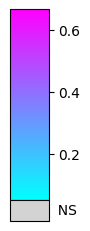

In [21]:
significant_sig_metadata = sig_metadata[sig_metadata.p_value < 0.05]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(0.5, 2.75), gridspec_kw={'height_ratios': [9, 1]})

cmap = mpl.cm.cool
# Use minimum and maximum cs values from significant_sig_metadata
norm = mpl.colors.Normalize(vmin=significant_sig_metadata.cs.min(), vmax=significant_sig_metadata.cs.max())

mapper = cm.ScalarMappable(norm=norm, cmap=cm.cool)

cbl = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='vertical')

# Create a separate color bar for the grey color
cmap_grey = mpl.colors.ListedColormap(['lightgrey'])
norm_grey = mpl.colors.Normalize(vmin=0, vmax=1)
cbl_grey = mpl.colorbar.ColorbarBase(ax2, cmap=cmap_grey, norm=norm_grey, orientation='vertical')

# Remove ticks and labels from the grey color bar
ax2.set_xticks([])
ax2.set_yticks([])

# Add a custom label for not-significant values
ax2.set_ylabel('  NS', fontsize=10, rotation=0, ha='left', va='center', labelpad=0)

# Adjust the space between the color bars to make them touch
plt.subplots_adjust(hspace=0)

plt.savefig('figures/R1_2D_pt2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_2D_pt2.svg', bbox_inches = 'tight')

plt.show()


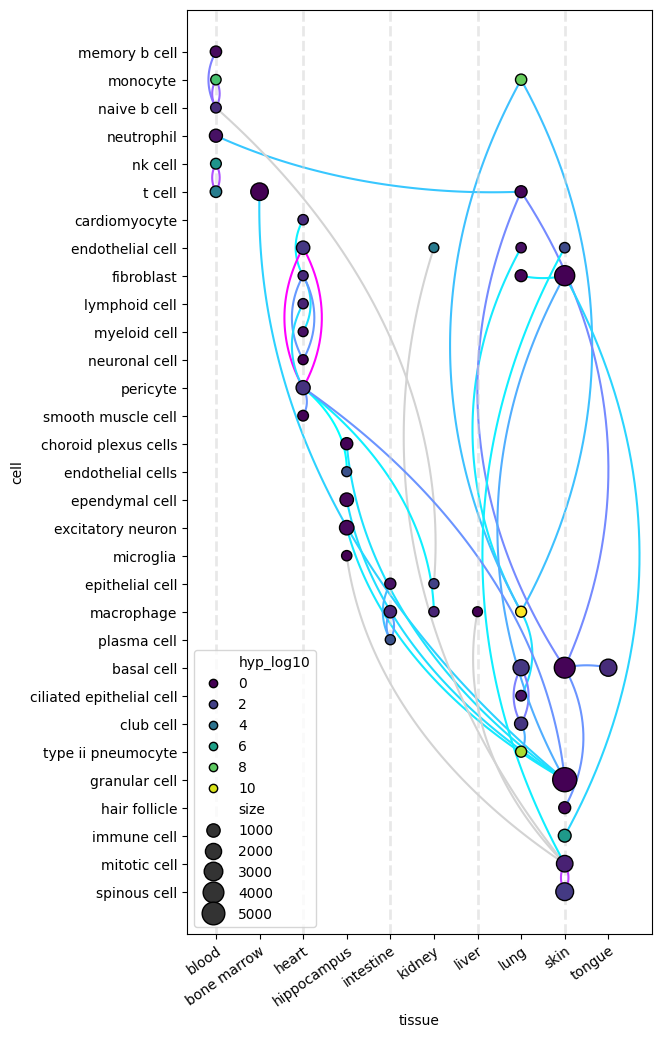

In [22]:

plt.figure(figsize = (6,12))


kwargs = {'edgecolors':'k'}


ax = sns.scatterplot(data = sig_metadata, x = "tissue", y = "cell", hue = 'hyp_log10', size = 'size',
                     sizes = (50, 300), palette = 'viridis', edgecolors = 'black', linewidth = 1)


for i in range(len(sig_metadata)):
    
    s = [sig_metadata.iloc[i].X, sig_metadata.iloc[i].Y]
    e = [sig_metadata.iloc[i].other_X, sig_metadata.iloc[i].other_y]
    
    
    #color = mapper.to_rgba(sig_metadata.iloc[i].cs)
    
    #I now make the lines grey if not significant
    p_value = sig_metadata.iloc[i].p_value
    if p_value < 0.05:
        color = mapper.to_rgba(sig_metadata.iloc[i].cs)
    else:
        color = 'lightgrey'
    
    is_significant = p_value < 0.05
    alpha = 1 if not is_significant else 1.0 #0.2
    
    ax.plot( *draw_arch(s, e, r_mult = 1.5), c=color,ls='-' , zorder = 0, alpha = alpha)

for x, y in enumerate(sig_metadata.tissue.unique()):
    if x%2 == 0:
        ax.axvline(x=y, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)

plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')


plt.xlim(right = 10)

plt.savefig('figures/R1_2D_pt1.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_2D_pt1.svg', dpi = 600, bbox_inches = 'tight', transparent = True)

plt.show()

In [23]:
sig_metadata

,tissue,cell,size,n_sen,hyp,X,Y,hyp_log10,top_match,cs,p_value,other_X,other_y
0,blood,memory b cell,430,4,4.690036e-01,0,0,0.328824,blood__naive b cell,0.359279,1.888696e-61,0,2
1,blood,monocyte,178,12,2.768281e-08,0,1,7.557790,blood__naive b cell,0.415042,3.165644e-65,0,2
2,blood,naive b cell,243,5,4.989007e-02,0,2,1.301986,blood__monocyte,0.415042,3.165644e-65,0,1
3,blood,neutrophil,915,9,3.345077e-01,0,3,0.475594,lung__t cell,0.187779,5.154007e-06,7,5
4,blood,nk cell,276,12,3.066311e-06,0,4,5.513384,blood__t cell,0.476378,1.045730e-156,0,5
5,blood,t cell,467,14,3.216635e-05,0,5,4.492598,blood__nk cell,0.476378,1.045730e-156,0,4
6,bone marrow,t cell,2542,9,9.992861e-01,1,5,0.000310,skin__granular cell,0.162809,0.000000e+00,8,26
7,heart,cardiomyocyte,175,4,5.592058e-02,2,6,1.252428,heart__fibroblast,0.085250,2.463623e-16,2,8
8,heart,endothelial cell,1010,15,1.906296e-02,2,7,1.719810,heart__pericyte,0.666186,0.000000e+00,2,12
9,heart,fibroblast,103,3,5.263947e-02,2,8,1.278689,heart__neuronal cell,0.298849,3.693826e-40,2,11


In [24]:
# for x in range(len(corr_counts)):
#     tissue = corr_counts.iloc[x].tissue
#     cell = corr_counts.iloc[x].cell_type_2
    
#     tester = corrs_sig[(corrs_sig.tissue == tissue) & (corrs_sig.cell_type_2 == cell)].copy()
#     tester['dif'] = tester.r - tester.rnd_r_q99
#     tester = tester[tester.dif > 0.02].sort_values('dif', ascending = False)
    
#     print(tissue, cell)
    
#     if len(tester) > 0:
#         try:
#             make_network(tester)
#         except:
#             pass
#     else:
#         print('no corrs ############')

In [25]:
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text


### Fig 2B part 2

In [30]:
tester

,tissue,cell_type_2,gene1,gene2,r,p,rnd_r_q99,dif
16343,hippocampus,choroid plexus cells,ADRA1A,SLC17A8,0.299467,0.000,0.049416,0.250052
16075,hippocampus,choroid plexus cells,ADRA1A,GPC6,0.273941,0.000,0.055061,0.218881
122948,hippocampus,choroid plexus cells,FREM2,SLC17A8,0.287797,0.000,0.069957,0.217840
38349,hippocampus,choroid plexus cells,ATP1A2,GPC6,0.280740,0.000,0.066728,0.214012
149857,hippocampus,choroid plexus cells,LAMA2,SLC17A8,0.255551,0.000,0.054796,0.200755
...,...,...,...,...,...,...,...,...
102735,hippocampus,choroid plexus cells,DUBR,PLAAT3,0.109331,0.002,0.059321,0.050010
35874,hippocampus,choroid plexus cells,ATAD1,CCSAP,0.107494,0.000,0.057485,0.050008
182743,hippocampus,choroid plexus cells,PEX14,SHISA9,0.119996,0.000,0.069987,0.050008
171779,hippocampus,choroid plexus cells,NDRG3,TGFBI,0.108847,0.000,0.058840,0.050006


/tmp/ipykernel_3525116/1881143788.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])


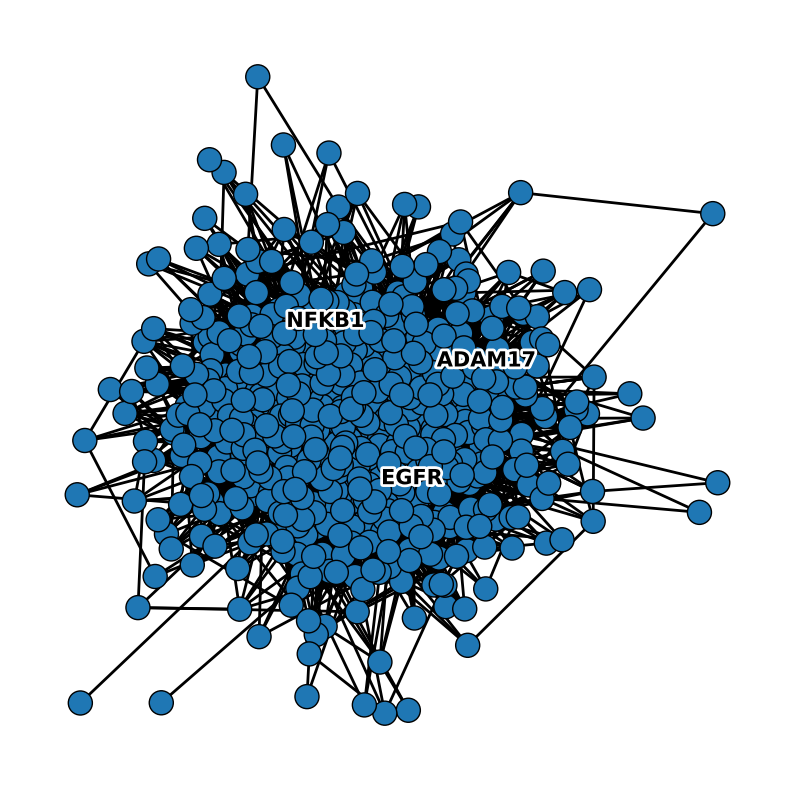

In [32]:
tester = corrs_sig[(corrs_sig.tissue == 'hippocampus') & (corrs_sig.cell_type_2 == 'choroid plexus cells')].copy()
tester['dif'] = tester.r - tester.rnd_r_q99

tester = tester[(tester.dif > 0.05) & (tester.r > 0.05)].sort_values('dif', ascending = False)
l = [x[0] for x in signatures[('hippocampus', 'choroid plexus cells')]]
tester = tester[(tester.gene1.isin(l)) & (tester.gene2.isin(l))]

G = nx.Graph()
#G = nx.petersen_graph()



for i, elrow in tester.iterrows():
    G.add_edge(elrow[2], elrow[3], weight=elrow[7])







clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(10,10))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items() if k in markers}

# nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
#                         font_weight='bold')





nx.draw_networkx_nodes(G, pos, 
                       node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
                       edgecolors = 'k')
nx.draw_networkx_edges(G, pos, width =  2)

texts = []
for k in node_lables:
    txt = plt.text(x = node_lables[k][0], y = node_lables[k][1], s = k,
                             fontsize = 15, weight = 'bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    texts.append(txt)

adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))
plt.gca().spines[['top', 'right', 'bottom', 'left']].set_visible(False)

plt.savefig('figures/R1_2B_pt2.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_2B_pt2.svg', bbox_inches = 'tight', transparent = True)

plt.show()

/tmp/ipykernel_1754138/2191713895.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])


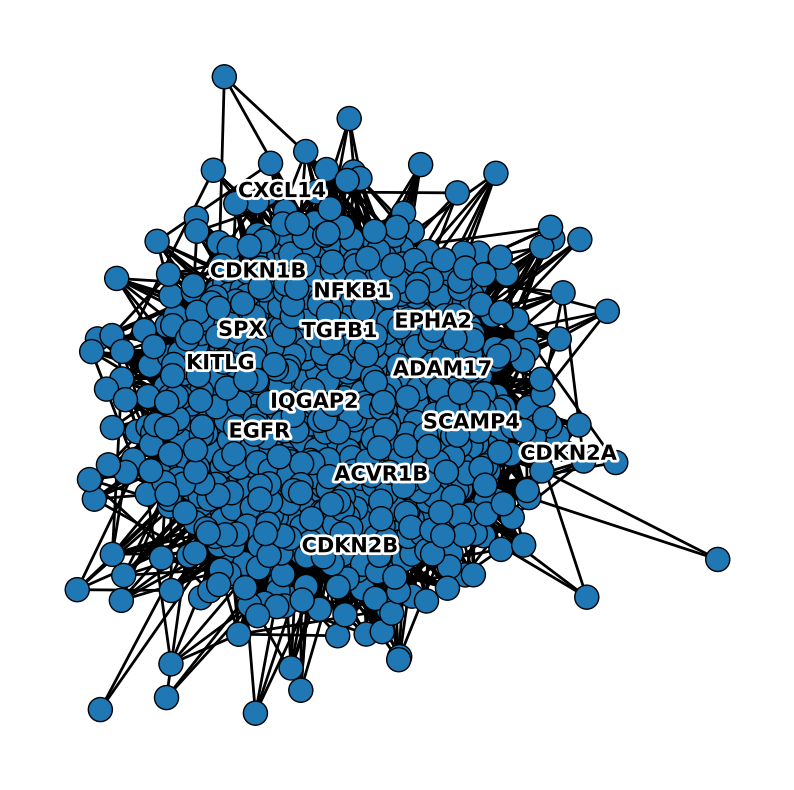

In [76]:
tester = corrs_sig[(corrs_sig.tissue == 'hippocampus') & (corrs_sig.cell_type_2 == 'choroid plexus cells')].copy()
tester['dif'] = tester.r - tester.rnd_r_q99

tester = tester[(tester.dif > 0.05) & (tester.r > 0.05)].sort_values('dif', ascending = False)
tester[(tester.gene1.isin(l)) & (tester.gene2.isin(l))]
tester = tester[(tester.gene1.isin(l)) & (tester.gene2.isin(l))]

G = nx.Graph()
#G = nx.petersen_graph()



for i, elrow in tester.iterrows():
    G.add_edge(elrow[2], elrow[3], weight=elrow[7])







clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(10,10))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items() if k in markers}

# nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
#                         font_weight='bold')





nx.draw_networkx_nodes(G, pos, 
                       node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
                       edgecolors = 'k')
nx.draw_networkx_edges(G, pos, width =  2)

texts = []
for k in node_lables:
    txt = plt.text(x = node_lables[k][0], y = node_lables[k][1], s = k,
                             fontsize = 15, weight = 'bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    texts.append(txt)

adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))
plt.gca().spines[['top', 'right', 'bottom', 'left']].set_visible(False)

plt.savefig('figures/2B_pt2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/2B_pt2.svg', bbox_inches = 'tight')

plt.show()